## Contributions

In [33]:
%run setup.ipynb
import json
from scipy.stats import chi2
import sys

In [39]:
base_dir = os.path.abspath(os.path.join(cwd, "../"))  # For interactive mode (Jupyter/IPython)
pythonPath = os.path.join(base_dir, 'python', 'nonstationaryGEV')
sys.path.append(pythonPath)

from imports import make_directoryDict


In [40]:
# set up directories to read from
dirs = make_directoryDict(base_dir)

In [41]:
recordID =552
climateIndex = ['AO','AAO','BEST','DMI','ONI','PDO','PMM','PNA','TNA']

In [42]:
#%%
# Initialize an empty list to store results
results = []
SignifCvte1 = np.zeros(len(climateIndex))
w_trend = np.zeros(len(climateIndex))
w_cvte1 = np.zeros(len(climateIndex))

for i in np.arange(0, len(climateIndex)):

    #read first value of w from trend_params.json
    trend_params = 'trend_params.json'
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / trend_params
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        w_trend[i] = output['w'][0]

    covariate_params = f'cvte_location_params_{climateIndex[i]}.json'
    
    # Create the full path for the JSON file
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / covariate_params

    # Open and read the JSON file
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        w, mio, standard_error = (np.array(output[key]) for key in ['w', 'mio', 'standard_error'])

    # Store the results in a list
    results.append({
        'Climate Index': climateIndex[i],
        'Amplitude of CI param': w[-1],  
        'Standard Error of CI param': standard_error[-1]
    })

    w_cvte1[i] = w[0]
    diffe = w_cvte1[i] - w_trend[i]
    p = 1
    SignifCvte1[i] = chi2.cdf(2 * diffe, p)

# Convert the results list to a DataFrame
df_cvteLocation = pd.DataFrame(results)

# add Significance to the dataframe
df_cvteLocation['Significance (over trend)'] = SignifCvte1

df_cvteLocation


,Climate Index,Amplitude of CI param,Standard Error of CI param,Significance (over trend)
0,AO,0.001196,0.004914,0.192309
1,AAO,0.003851,0.005167,0.542692
2,BEST,0.004717,0.004508,0.703882
3,DMI,0.007385,0.004867,0.870542
4,ONI,0.001423,0.004277,0.260503
5,PDO,0.025943,0.004708,1.000000
6,PMM,0.022704,0.004254,1.000000
7,PNA,0.008894,0.005613,0.884908
8,TNA,0.002389,0.004959,0.369332


In [43]:

#%%
# Initialize an empty list to store results
results = []
w_cvte2 = np.zeros(len(climateIndex))
SignifCvte2_loc = np.zeros(len(climateIndex))
SignifCvte2_T = np.zeros(len(climateIndex))

for i in np.arange(0, len(climateIndex)):
    covariate_params = f'cvte_scale_params_{climateIndex[i]}.json'
    
    # Create the full path for the JSON file
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / covariate_params

    # Open and read the JSON file
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        w, mio, standard_error = (np.array(output[key]) for key in ['w', 'mio', 'standard_error'])

    if standard_error[-1] == 0:
        standard_error[-1] = np.nan

    # Store the results in a list
    results.append({
        'Climate Index': climateIndex[i],
        'Amplitude of CI param': w[-1],  
        'Standard Error of CI param': standard_error[-1]
    })

    w_cvte2[i] = w[0]

    diffe = w_cvte2[i] - w_trend[i]
    p = 1
    SignifCvte2_T[i] = chi2.cdf(2 * diffe, p)

    diffe = w_cvte2[i] - w_cvte1[i]
    p = 1
    SignifCvte2_loc[i] = chi2.cdf(2 * diffe, p)    

# Convert the results list to a DataFrame
df_cvteScale = pd.DataFrame(results)

# # add Significance to the dataframe
df_cvteScale['Significance over cvte_loc'] = SignifCvte2_loc
df_cvteScale['Significance over trend'] = SignifCvte2_T

df_cvteScale

,Climate Index,Amplitude of CI param,Standard Error of CI param,Significance over cvte_loc,Significance over trend
0,AO,0.001923,0.002537,0.526790,0.551214
1,AAO,0.005635,0.002914,0.913781,0.938485
2,BEST,-0.005200,0.002915,0.859094,0.928995
3,DMI,0.004616,0.003274,0.000000,0.842227
4,ONI,-0.004842,0.003005,0.881420,0.889465
5,PDO,-0.009627,0.002355,0.999882,1.000000
6,PMM,-0.003893,0.003089,0.806268,1.000000
7,PNA,0.006565,0.003546,0.696739,0.940191
8,TNA,0.004041,0.003129,0.761526,0.797013


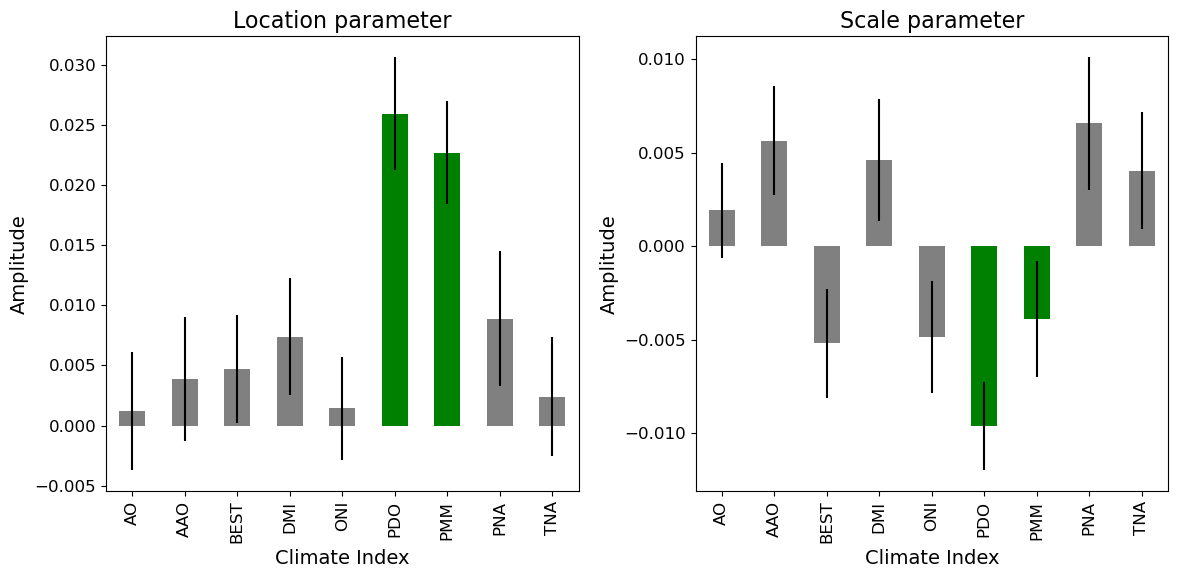

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors based on significance
location_colors = np.where(df_cvteLocation['Significance (over trend)']>0.95, 'green', 'gray')
scale_colors = np.where(df_cvteScale['Significance over trend']>0.95, 'green', 'gray')

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Location parameter with custom colors for significance
df_cvteLocation.plot(
    x='Climate Index', 
    y='Amplitude of CI param', 
    yerr='Standard Error of CI param', 
    kind='bar', 
    ax=ax[0], 
    color=location_colors
)
ax[0].set_title('Location parameter')
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('Climate Index')

# Plot the Scale parameter with custom colors for significance
df_cvteScale.plot(
    x='Climate Index', 
    y='Amplitude of CI param', 
    yerr='Standard Error of CI param', 
    kind='bar', 
    ax=ax[1], 
    color=scale_colors
)
ax[1].set_title('Scale parameter')
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Climate Index')

# no legend
ax[0].get_legend().remove()
ax[1].get_legend().remove()

plt.tight_layout()
plt.show()
